# Clustering Tasks

## Task 1: Data Preprocessing
Clean and prepare your data.
- Use appropriate preprocessing techniques to ensure the dataset is ready for clustering.
- **Note:** You can reuse or build upon the data cleaning steps from the previous assignments.

Assumptions for Clustering:
- Data is normalized

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings("ignore")

# Sklearn imports for preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# Clustering algorithms
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score

# Dimensionality reduction for visualization
from sklearn.decomposition import PCA

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# Load the dataset
FinTech = pd.read_csv("../Hausarbeit/dataset.csv")
print(f"Dataset shape: {FinTech.shape}")
FinTech.head()

Dataset shape: (8662, 22)


,Customer_ID,CCreditScore,CGeography,CGender,CAge,CTenure,CBalance,CNumOfProducts,CHasCrCard,CIsActiveMember,...,Account_Age_Months,Avg_Monthly_Transactions,Transaction_Variance,Last_Login_Days_Ago,Support_Tickets_Count,Mobile_App_Usage_Hours,Onboarding_Month,Is_Holiday_Onboarding,Churn,CLV_Continuous
0,CUST_000001,553.295220,France,Male,39,2,131008.168572,1,1,0,...,36.942433,8,4.959478,1.094710,1,7.979899,8,0,0,21696.256022
1,CUST_000002,552.939394,France,Male,33,4,118529.788812,1,0,0,...,23.748871,11,9.866506,14.809607,0,11.565167,11,0,0,15918.891128
2,CUST_000003,688.745934,Spain,Male,40,1,-879.724555,2,1,1,...,1.114543,13,6.178311,26.434273,0,3.331838,2,0,0,10361.315773
3,CUST_000004,771.940664,France,Male,40,9,125563.132706,1,1,0,...,1.662811,12,4.509500,18.540471,2,12.714742,1,1,0,15189.776245
4,CUST_000005,484.092560,France,Male,55,5,95759.918567,1,0,1,...,24.007725,8,18.786985,11.893918,1,0.719512,2,0,0,14631.814966


### Data Cleaning (Reused from Assignment 1 & 2)

The following preprocessing steps are adapted from the previous assignments:
- Clean object columns (strip whitespace, capitalize)
- Fix geography spelling variations
- Drop duplicates
- Handle value range violations
- Fix logical constraints between temporal features

For Clustering there are follwing assumptions that we have to consider during pre-processing:
- normalized data
- scaled data


In [3]:
FinTech_cleaned = FinTech.copy()

# Clean object columns
def clean_obj_cols(df):
    obj_cols = df.select_dtypes(include=["object"]).columns
    for col in obj_cols:
        df[col] = df[col].str.strip().str.capitalize()
    return df

FinTech_cleaned = clean_obj_cols(FinTech_cleaned)

# Fix geography spelling variations
geography_mapping = {"Fr": "France", "De": "Germany", "Es": "Spain"}
FinTech_cleaned["CGeography"] = FinTech_cleaned["CGeography"].replace(geography_mapping)

# Drop duplicates
FinTech_cleaned = FinTech_cleaned.drop_duplicates()
print(f"Dataset shape after removing duplicates: {FinTech_cleaned.shape}")

Dataset shape after removing duplicates: (8662, 22)


In [4]:
# Define valid ranges for features
valid_ranges = {
    "CCreditScore": (0, None), 
    "CAge": (0, 125),
    'CTenure': (0, None),               
    "CNumOfProducts": (1, 4),        
    "CHasCrCard": (0, 1),
    'CIsActiveMember': (0, 1),
    "CEstimatedSalary": (0, None),
    "Days_Since_Onboarding": (0, None),
    "Account_Age_Months": (0, None),
    "Avg_Monthly_Transactions": (0, None),
    "Transaction_Variance": (0, None),
    "Last_Login_Days_Ago": (0, None),
    "Support_Tickets_Count": (0, None),
    "Mobile_App_Usage_Hours": (0, None),
    "Onboarding_Month": (1, 12),
    "Is_Holiday_Onboarding": (0, 1),
    "Churn": (0, 1),
    "CLV_Continuous": (0, None)
}

def handle_range_violations(df, column, min_val, max_val, strategy='impute'):
    """Handle range violations by imputing with median of valid values."""
    df = df.copy()
    if column not in df.columns:
        return df

    if min_val is not None and max_val is not None:
        invalid_mask = (df[column] < min_val) | (df[column] > max_val)
    elif min_val is not None:
        invalid_mask = df[column] < min_val
    elif max_val is not None:
        invalid_mask = df[column] > max_val
    else:
        return df

    n_invalid = int(invalid_mask.sum())
    if n_invalid == 0:
        return df

    if strategy == 'impute':
        valid_mask = (~invalid_mask) & df[column].notna()
        replacement = df.loc[valid_mask, column].median(skipna=True) if valid_mask.sum() > 0 else df[column].median(skipna=True)
        if not pd.isna(replacement):
            df.loc[invalid_mask, column] = replacement
    
    return df

# Apply range validation
for column, (min_val, max_val) in valid_ranges.items():
    FinTech_cleaned = handle_range_violations(FinTech_cleaned, column, min_val, max_val, 'impute')

# Fix temporal constraints
days_per_month = 30.44

# Constraint 1: Age >= Tenure
violations = FinTech_cleaned[FinTech_cleaned['CAge'] < FinTech_cleaned['CTenure']].index
for idx in violations:
    FinTech_cleaned.loc[idx, 'CTenure'] = min(FinTech_cleaned.loc[idx, 'CTenure'], FinTech_cleaned.loc[idx, 'CAge'])

# Constraint 2: Onboarding consistency
expected_months = FinTech_cleaned['Days_Since_Onboarding'] / days_per_month
discrepancy = abs(FinTech_cleaned['Account_Age_Months'] - expected_months)
violations = FinTech_cleaned[discrepancy > 1].index
for idx in violations:
    FinTech_cleaned.loc[idx, 'Days_Since_Onboarding'] = FinTech_cleaned.loc[idx, 'Account_Age_Months'] * days_per_month

# Constraint 3: Last login <= Account age
account_age_days = FinTech_cleaned['Account_Age_Months'] * days_per_month
violations = FinTech_cleaned[FinTech_cleaned['Last_Login_Days_Ago'] > account_age_days].index
for idx in violations:
    FinTech_cleaned.loc[idx, 'Last_Login_Days_Ago'] = max(1, FinTech_cleaned.loc[idx, 'Account_Age_Months'] * days_per_month - 1)

print("Data cleaning completed.")

Data cleaning completed.


### Feature Selection for Clustering

For customer segmentation, we select features that capture customer behavior and characteristics relevant for marketing segmentation:
- **Demographics**: Age, Geography, Gender
- **Financial behavior**: Credit Score, Balance, Number of Products, Estimated Salary, CLV
- **Engagement**: Tenure, Active Member status, Mobile App Usage, Average Transactions, Support Tickets
- **Temporal**: Account Age, Last Login Days

We exclude identifiers (`Customer_ID`) and the binary target variable (`Churn`) as it represents an outcome rather than a segmentation feature.

In [5]:
# Define features for clustering
# Exclude Customer_ID and Churn (outcome variable)
exclude_cols = ['Customer_ID', 'Churn']

# Select features for clustering
X_clustering = FinTech_cleaned.drop(columns=exclude_cols)

# Define categorical and numerical columns
cat_cols = ["CGeography", "CGender"]
num_cols = [col for col in X_clustering.columns if col not in cat_cols]

print(f"Numerical features ({len(num_cols)}): {num_cols}")
print(f"Categorical features ({len(cat_cols)}): {cat_cols}")

Numerical features (18): ['CCreditScore', 'CAge', 'CTenure', 'CBalance', 'CNumOfProducts', 'CHasCrCard', 'CIsActiveMember', 'CEstimatedSalary', 'Days_Since_Onboarding', 'Account_Age_Months', 'Avg_Monthly_Transactions', 'Transaction_Variance', 'Last_Login_Days_Ago', 'Support_Tickets_Count', 'Mobile_App_Usage_Hours', 'Onboarding_Month', 'Is_Holiday_Onboarding', 'CLV_Continuous']
Categorical features (2): ['CGeography', 'CGender']


In [6]:
# Custom Outlier Winsorizer (reused from Assignment 2)
class OutlierWinsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, multiplier=3):
        self.multiplier = multiplier
        self.bounds_ = {}
    
    def fit(self, X, y=None):
        X = np.array(X)
        for i in range(X.shape[1]):
            mean = np.nanmean(X[:, i])
            std = np.nanstd(X[:, i])
            self.bounds_[i] = (mean - self.multiplier * std, mean + self.multiplier * std)
        return self
    
    def transform(self, X):
        X = np.array(X).copy()
        for i in range(X.shape[1]):
            lower, upper = self.bounds_[i]
            X[:, i] = np.clip(X[:, i], lower, upper)
        return X
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array([f'x{i}' for i in range(len(self.bounds_))])
        return np.array(input_features)

In [7]:
# Create preprocessing pipeline for clustering
# Numerical: Impute -> Winsorize Outliers -> Power Transform -> Scale (StandardScaler for clustering)
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('outlier', OutlierWinsorizer(multiplier=3)),
    ('power', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())  # StandardScaler is preferred for K-Means
])

# Categorical: Impute -> One-Hot Encode
from sklearn.preprocessing import OneHotEncoder
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

# Fit and transform the data
X_processed = preprocessor.fit_transform(X_clustering)
feature_names = preprocessor.get_feature_names_out()

# Create DataFrame for easier analysis
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)
print(f"Processed data shape: {X_processed_df.shape}")
X_processed_df.head()

Processed data shape: (8662, 21)


,num__CCreditScore,num__CAge,num__CTenure,num__CBalance,num__CNumOfProducts,num__CHasCrCard,num__CIsActiveMember,num__CEstimatedSalary,num__Days_Since_Onboarding,num__Account_Age_Months,...,num__Transaction_Variance,num__Last_Login_Days_Ago,num__Support_Tickets_Count,num__Mobile_App_Usage_Hours,num__Onboarding_Month,num__Is_Holiday_Onboarding,num__CLV_Continuous,cat__CGeography_Germany,cat__CGeography_Spain,cat__CGender_Male
0,-1.015363,0.281206,-1.035567,0.862691,-1.029284,0.645561,-1.087136,1.278936,1.547319,1.540314,...,-0.370903,-2.217167,1.170370,0.926113,0.488454,-0.457460,1.425629,0.0,0.0,1.0
1,-1.018970,-0.391573,-0.287948,0.722376,-1.029284,-1.549041,-1.087136,-0.026997,0.990217,1.012248,...,0.590899,0.191559,-0.770664,1.352748,1.254565,-0.457460,0.443207,0.0,0.0,1.0
2,0.381807,0.380404,-1.454613,-1.205209,0.911769,0.645561,0.919848,0.817355,-1.460525,-1.503510,...,-0.082836,1.066906,-0.770664,-0.017397,-1.327188,-0.457460,-0.571756,0.0,1.0,1.0
3,1.261546,0.380404,1.317959,0.801788,-1.029284,0.645561,-1.087136,-0.465962,-1.246269,-1.301403,...,-0.489878,0.514994,1.532301,1.463091,-1.707412,2.185982,0.314622,0.0,0.0,1.0
4,-1.710023,1.567905,0.056763,0.458815,-1.029284,-1.549041,0.919848,-0.346031,1.003096,1.024750,...,1.647753,-0.105138,1.170370,-1.248886,-1.327188,-0.457460,0.215401,0.0,0.0,1.0


In [8]:
# Verify normalization - check mean and std of numerical features
num_feature_names = [f for f in feature_names if f.startswith('num__')]
print("Verification of normalization (numerical features):")
print(f"Mean close to 0: {X_processed_df[num_feature_names].mean().abs().max():.6f}")
print(f"Std close to 1: {X_processed_df[num_feature_names].std().mean():.6f}")
print("\nSummary statistics of processed features:")
X_processed_df.describe().round(3)

Verification of normalization (numerical features):
Mean close to 0: 0.000000
Std close to 1: 1.000058

Summary statistics of processed features:


,num__CCreditScore,num__CAge,num__CTenure,num__CBalance,num__CNumOfProducts,num__CHasCrCard,num__CIsActiveMember,num__CEstimatedSalary,num__Days_Since_Onboarding,num__Account_Age_Months,...,num__Transaction_Variance,num__Last_Login_Days_Ago,num__Support_Tickets_Count,num__Mobile_App_Usage_Hours,num__Onboarding_Month,num__Is_Holiday_Onboarding,num__CLV_Continuous,cat__CGeography_Germany,cat__CGeography_Spain,cat__CGender_Male
count,8662.000,8662.000,8662.000,8662.000,8662.000,8662.000,8662.000,8662.000,8662.000,8662.000,...,8662.000,8662.000,8662.000,8662.000,8662.000,8662.000,8662.000,8662.000,8662.000,8662.000
mean,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,...,0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.225,0.255,0.565
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.418,0.436,0.496
min,-2.978,-3.108,-1.931,-4.230,-1.029,-1.549,-1.087,-2.217,-2.638,-2.118,...,-2.723,-2.777,-0.771,-1.989,-1.707,-0.457,-2.534,0.000,0.000,0.000
25%,-0.698,-0.652,-0.650,-0.907,-1.029,-1.549,-1.087,-0.741,-0.708,-0.744,...,-0.729,-0.695,-0.771,-0.781,-0.981,-0.457,-0.823,0.000,0.000,0.000
50%,0.007,-0.037,0.057,0.434,0.912,0.646,0.920,0.079,0.009,0.018,...,0.019,-0.004,-0.771,0.024,-0.062,-0.457,0.105,0.000,0.000,1.000
75%,0.684,0.570,0.707,0.812,0.912,0.646,0.920,0.807,0.718,0.745,...,0.701,0.696,1.170,0.748,0.751,-0.457,0.805,0.000,1.000,1.000
max,2.181,2.338,1.612,1.806,2.359,0.646,0.920,1.734,2.066,2.007,...,2.159,2.179,1.651,2.008,1.498,2.186,2.616,1.000,1.000,1.000


### Solution

The preprocessing pipeline for clustering analysis has been successfully adapted from the previous assignments. Key steps include:

1. **Data Cleaning**: Handled format inconsistencies, spelling variations, duplicates, and range violations
2. **Temporal Constraint Fixing**: Ensured logical consistency between Age/Tenure, Onboarding/Account Age, and Last Login
3. **Feature Engineering**: Selected relevant features for customer segmentation (excluding identifiers and outcome variables)
4. **Normalization Pipeline**:
   - Missing value imputation (median for numerical, mode for categorical)
   - Outlier winsorization (3 standard deviations)
   - Power transformation (Yeo-Johnson) for numerical features
   - StandardScaler normalization (mean=0, std=1) - critical for K-Means clustering
   - One-hot encoding for categorical features

The data is now normalized and ready for clustering algorithms.

## Task 2: Clustering Analysis
Use the preprocessed data and clustering algorithms to identify distinct customer groups.

- Use clustering to segment your customers into meaningful groups.
- Determine the optimal number of clusters and evaluate the quality of your clusters using
appropriate metrics.

### Determining Optimal Number of Clusters

To find the optimal number of clusters, we use multiple evaluation methods:
1. **Elbow Method**: Plot inertia (within-cluster sum of squares) vs. number of clusters
2. **Silhouette Score**: Measures how similar points are to their own cluster compared to other clusters (higher is better, range: -1 to 1)
3. **Calinski-Harabasz Index**: Ratio of between-cluster to within-cluster dispersion (higher is better)
4. **Davies-Bouldin Index**: Average similarity between clusters (lower is better)

In [9]:
# Evaluate different numbers of clusters
k_range = range(2, 11)
inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10, max_iter=300)
    kmeans.fit(X_processed)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_processed, kmeans.labels_))
    calinski_scores.append(calinski_harabasz_score(X_processed, kmeans.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(X_processed, kmeans.labels_))

# Create evaluation metrics DataFrame
cluster_eval_df = pd.DataFrame({
    'k': list(k_range),
    'Inertia': inertias,
    'Silhouette': silhouette_scores,
    'Calinski-Harabasz': calinski_scores,
    'Davies-Bouldin': davies_bouldin_scores
})
print("Cluster Evaluation Metrics:")
cluster_eval_df.round(4)

Cluster Evaluation Metrics:


,k,Inertia,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,2,146211.2317,0.0947,887.8551,3.0189
1,3,138724.5160,0.0737,701.4902,3.0583
2,4,133784.2260,0.0690,591.4466,2.8341
3,5,130060.4478,0.0606,518.1951,3.0691
4,6,127053.2460,0.0633,465.2970,3.0471
5,7,123649.8517,0.0637,438.0767,2.9589
6,8,121950.9305,0.0569,397.9044,3.0353
7,9,120565.3976,0.0547,364.5562,3.1400
8,10,118772.2180,0.0502,343.4187,3.0077


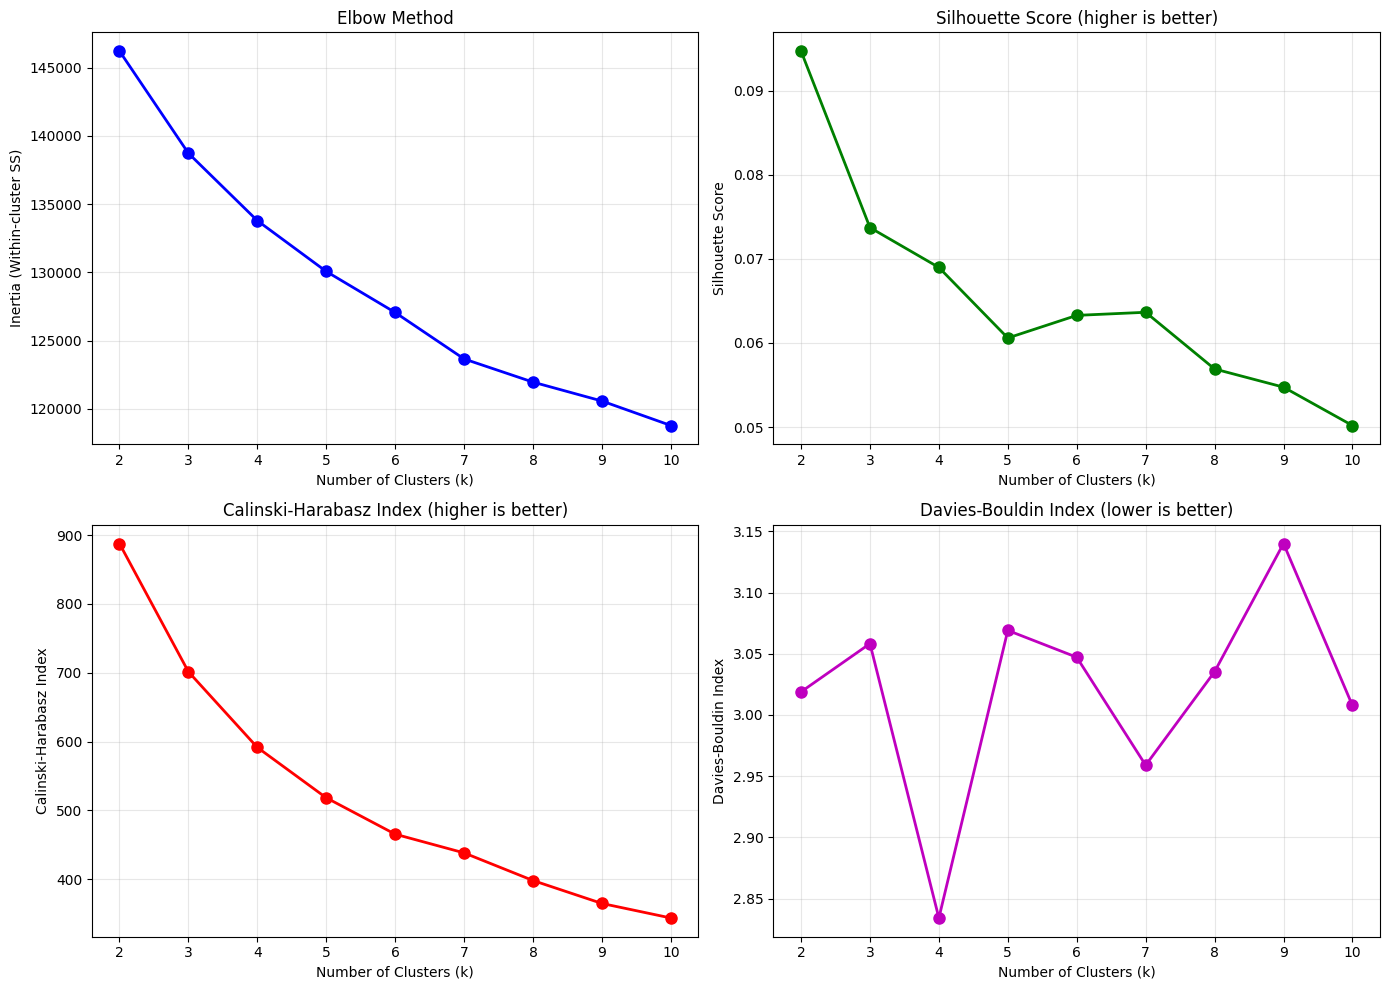


Optimal k based on:
  - Silhouette Score: k = 2
  - Calinski-Harabasz Index: k = 2
  - Davies-Bouldin Index: k = 4


In [10]:
# Visualize cluster evaluation metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Elbow Method
axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia (Within-cluster SS)')
axes[0, 0].set_title('Elbow Method')
axes[0, 0].grid(True, alpha=0.3)

# Silhouette Score
axes[0, 1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score (higher is better)')
axes[0, 1].grid(True, alpha=0.3)

# Calinski-Harabasz Index
axes[1, 0].plot(k_range, calinski_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Calinski-Harabasz Index')
axes[1, 0].set_title('Calinski-Harabasz Index (higher is better)')
axes[1, 0].grid(True, alpha=0.3)

# Davies-Bouldin Index
axes[1, 1].plot(k_range, davies_bouldin_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_ylabel('Davies-Bouldin Index')
axes[1, 1].set_title('Davies-Bouldin Index (lower is better)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal k based on metrics
best_silhouette_k = cluster_eval_df.loc[cluster_eval_df['Silhouette'].idxmax(), 'k']
best_calinski_k = cluster_eval_df.loc[cluster_eval_df['Calinski-Harabasz'].idxmax(), 'k']
best_davies_k = cluster_eval_df.loc[cluster_eval_df['Davies-Bouldin'].idxmin(), 'k']

print(f"\nOptimal k based on:")
print(f"  - Silhouette Score: k = {best_silhouette_k}")
print(f"  - Calinski-Harabasz Index: k = {best_calinski_k}")
print(f"  - Davies-Bouldin Index: k = {best_davies_k}")

### Silhouette Analysis

The silhouette plot shows how well each sample is clustered. A good clustering has most samples with high positive silhouette coefficients, and all clusters should have similar thickness (cluster sizes).

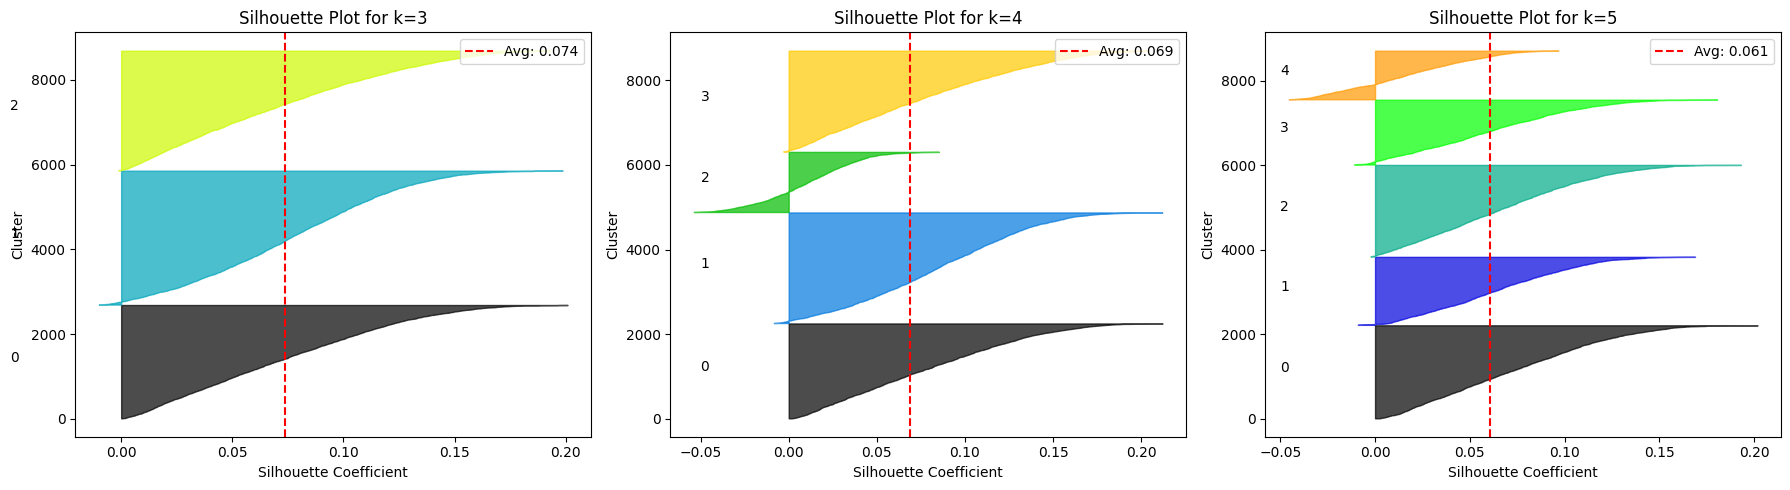

In [11]:
# Silhouette analysis for k=3, 4, and 5
from matplotlib import cm

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, k in enumerate([3, 4, 5]):
    ax = axes[idx]
    
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    cluster_labels = kmeans.fit_predict(X_processed)
    
    silhouette_avg = silhouette_score(X_processed, cluster_labels)
    sample_silhouette_values = silhouette_samples(X_processed, cluster_labels)
    
    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax.axvline(x=silhouette_avg, color="red", linestyle="--", label=f'Avg: {silhouette_avg:.3f}')
    ax.set_title(f"Silhouette Plot for k={k}")
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster")
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Final Clustering Model

Based on the evaluation metrics:
- The **Elbow Method** shows diminishing returns after k=4-5
- **Silhouette Score** suggests k=2-3 has the highest scores, but smaller k values may oversimplify customer segments
- **Calinski-Harabasz** and **Davies-Bouldin** indices support k=3-4

Considering both statistical metrics and business interpretability (having enough distinct segments for targeted marketing while keeping them manageable), we select **k=4** as the optimal number of clusters.

In [23]:
# Train final K-Means model with k=4
OPTIMAL_K = 4

kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=RANDOM_STATE, n_init=10, max_iter=300)
cluster_labels = kmeans_final.fit_predict(X_processed)

# Add cluster labels to the original cleaned data
FinTech_clustered = FinTech_cleaned.copy()
FinTech_clustered['Cluster'] = cluster_labels

# Print cluster sizes
print("Cluster Distribution:")
cluster_counts = FinTech_clustered['Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"  Cluster {cluster}: {count} customers ({count/len(FinTech_clustered)*100:.1f}%)")

# Final evaluation metrics
print(f"\nFinal Model Evaluation Metrics (k={OPTIMAL_K}):")
print(f"  - Silhouette Score: {silhouette_score(X_processed, cluster_labels):.4f}")
print(f"  - Calinski-Harabasz Index: {calinski_harabasz_score(X_processed, cluster_labels):.2f}")
print(f"  - Davies-Bouldin Index: {davies_bouldin_score(X_processed, cluster_labels):.4f}")

Cluster Distribution:
  Cluster 0: 2244 customers (25.9%)
  Cluster 1: 2614 customers (30.2%)
  Cluster 2: 1422 customers (16.4%)
  Cluster 3: 2382 customers (27.5%)

Final Model Evaluation Metrics (k=4):
  - Silhouette Score: 0.0690
  - Calinski-Harabasz Index: 591.45
  - Davies-Bouldin Index: 2.8341


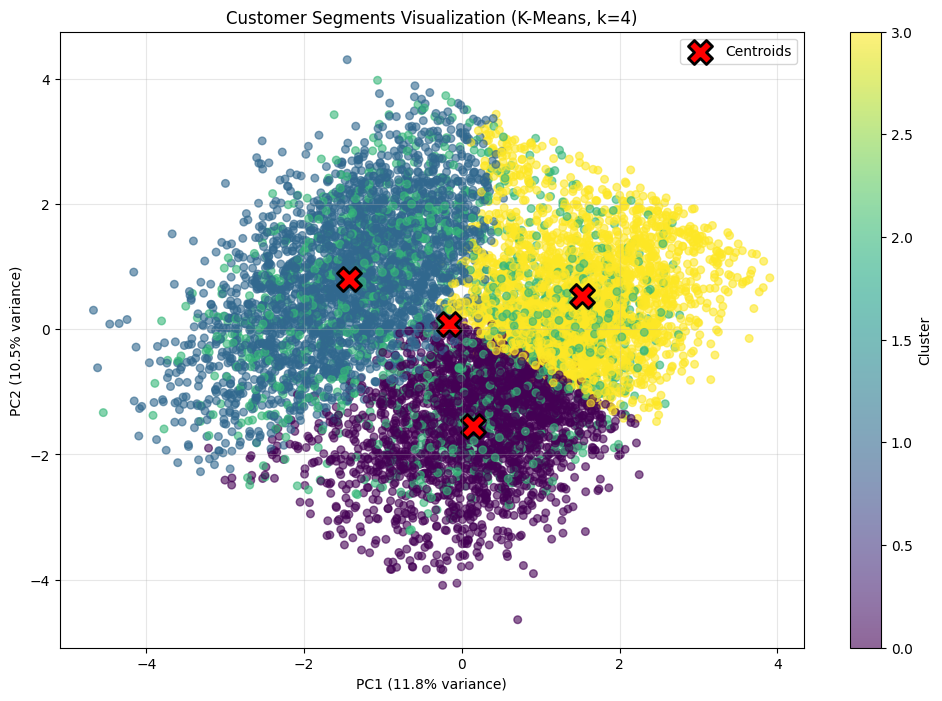


PCA explains 22.4% of total variance


In [24]:
# Visualize clusters using PCA (2D projection)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_processed)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, s=30)

# Plot cluster centers
centers_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', s=300, 
            edgecolors='black', linewidths=2, label='Centroids')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title(f'Customer Segments Visualization (K-Means, k={OPTIMAL_K})')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nPCA explains {pca.explained_variance_ratio_.sum()*100:.1f}% of total variance")

## Task 3: Cluster Profiling
Focus on the characteristics of each group.

- Analyze and describe each cluster by examining the characteristics of the customers within
the clusters.
- Compare the clusters and highlight key differences and similarities.
Visualize your clusters to present the differences.

### Cluster Statistics Summary

We analyze each cluster by examining the mean values of key features to understand the characteristics of customers in each segment.

In [25]:
# Calculate cluster profiles - mean values for key features
key_features = ['CCreditScore', 'CAge', 'CTenure', 'CBalance', 'CNumOfProducts', 
                'CEstimatedSalary', 'Avg_Monthly_Transactions', 'Mobile_App_Usage_Hours',
                'Support_Tickets_Count', 'Last_Login_Days_Ago', 'Account_Age_Months',
                'CLV_Continuous', 'Churn']

# Create cluster profile summary
cluster_profiles = FinTech_clustered.groupby('Cluster')[key_features].mean()
cluster_profiles = cluster_profiles.round(2)

# Add cluster size
cluster_profiles['Cluster_Size'] = FinTech_clustered.groupby('Cluster').size()
cluster_profiles['Cluster_Pct'] = (cluster_profiles['Cluster_Size'] / len(FinTech_clustered) * 100).round(1)

print("Cluster Profiles (Mean Values):")
cluster_profiles.T

Cluster Profiles (Mean Values):


Cluster,0,1,2,3
CCreditScore,649.51,648.80,647.46,655.27
CAge,37.86,37.70,37.93,38.32
CTenure,4.82,5.09,5.00,5.16
CBalance,117630.32,1853.11,69526.03,114106.39
CNumOfProducts,1.34,1.83,1.56,1.38
CEstimatedSalary,104303.12,94505.95,96859.58,106711.62
Avg_Monthly_Transactions,12.06,12.06,11.97,11.85
Mobile_App_Usage_Hours,4.99,4.93,4.96,5.12
Support_Tickets_Count,0.49,0.54,0.55,0.51
Last_Login_Days_Ago,14.66,15.73,15.59,16.32


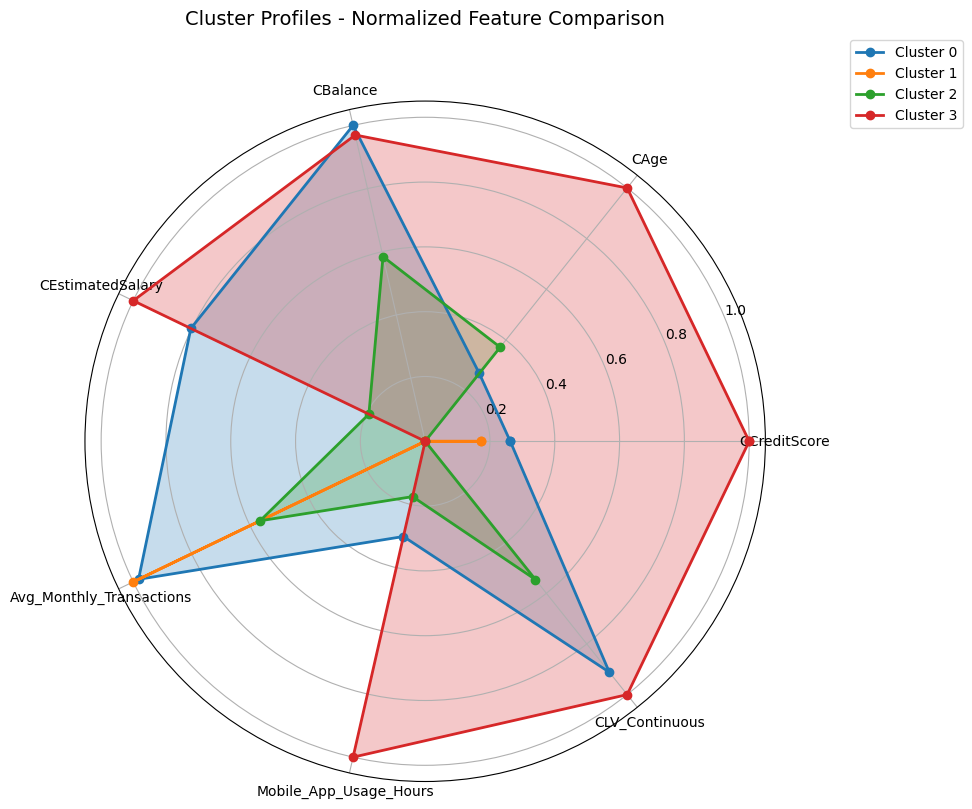

In [26]:
# Visualize cluster profiles - radar/spider chart for key metrics
from math import pi

# Select key metrics for radar chart (normalized for comparison)
radar_features = ['CCreditScore', 'CAge', 'CBalance', 'CEstimatedSalary', 
                  'Avg_Monthly_Transactions', 'Mobile_App_Usage_Hours', 'CLV_Continuous']

# Normalize features to 0-1 scale for radar chart
radar_data = FinTech_clustered.groupby('Cluster')[radar_features].mean()
radar_normalized = (radar_data - radar_data.min()) / (radar_data.max() - radar_data.min())

# Create radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

angles = np.linspace(0, 2 * pi, len(radar_features), endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for cluster_id in range(OPTIMAL_K):
    values = radar_normalized.loc[cluster_id].tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster_id}', color=colors[cluster_id])
    ax.fill(angles, values, alpha=0.25, color=colors[cluster_id])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_features, size=10)
ax.set_title('Cluster Profiles - Normalized Feature Comparison', size=14, y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

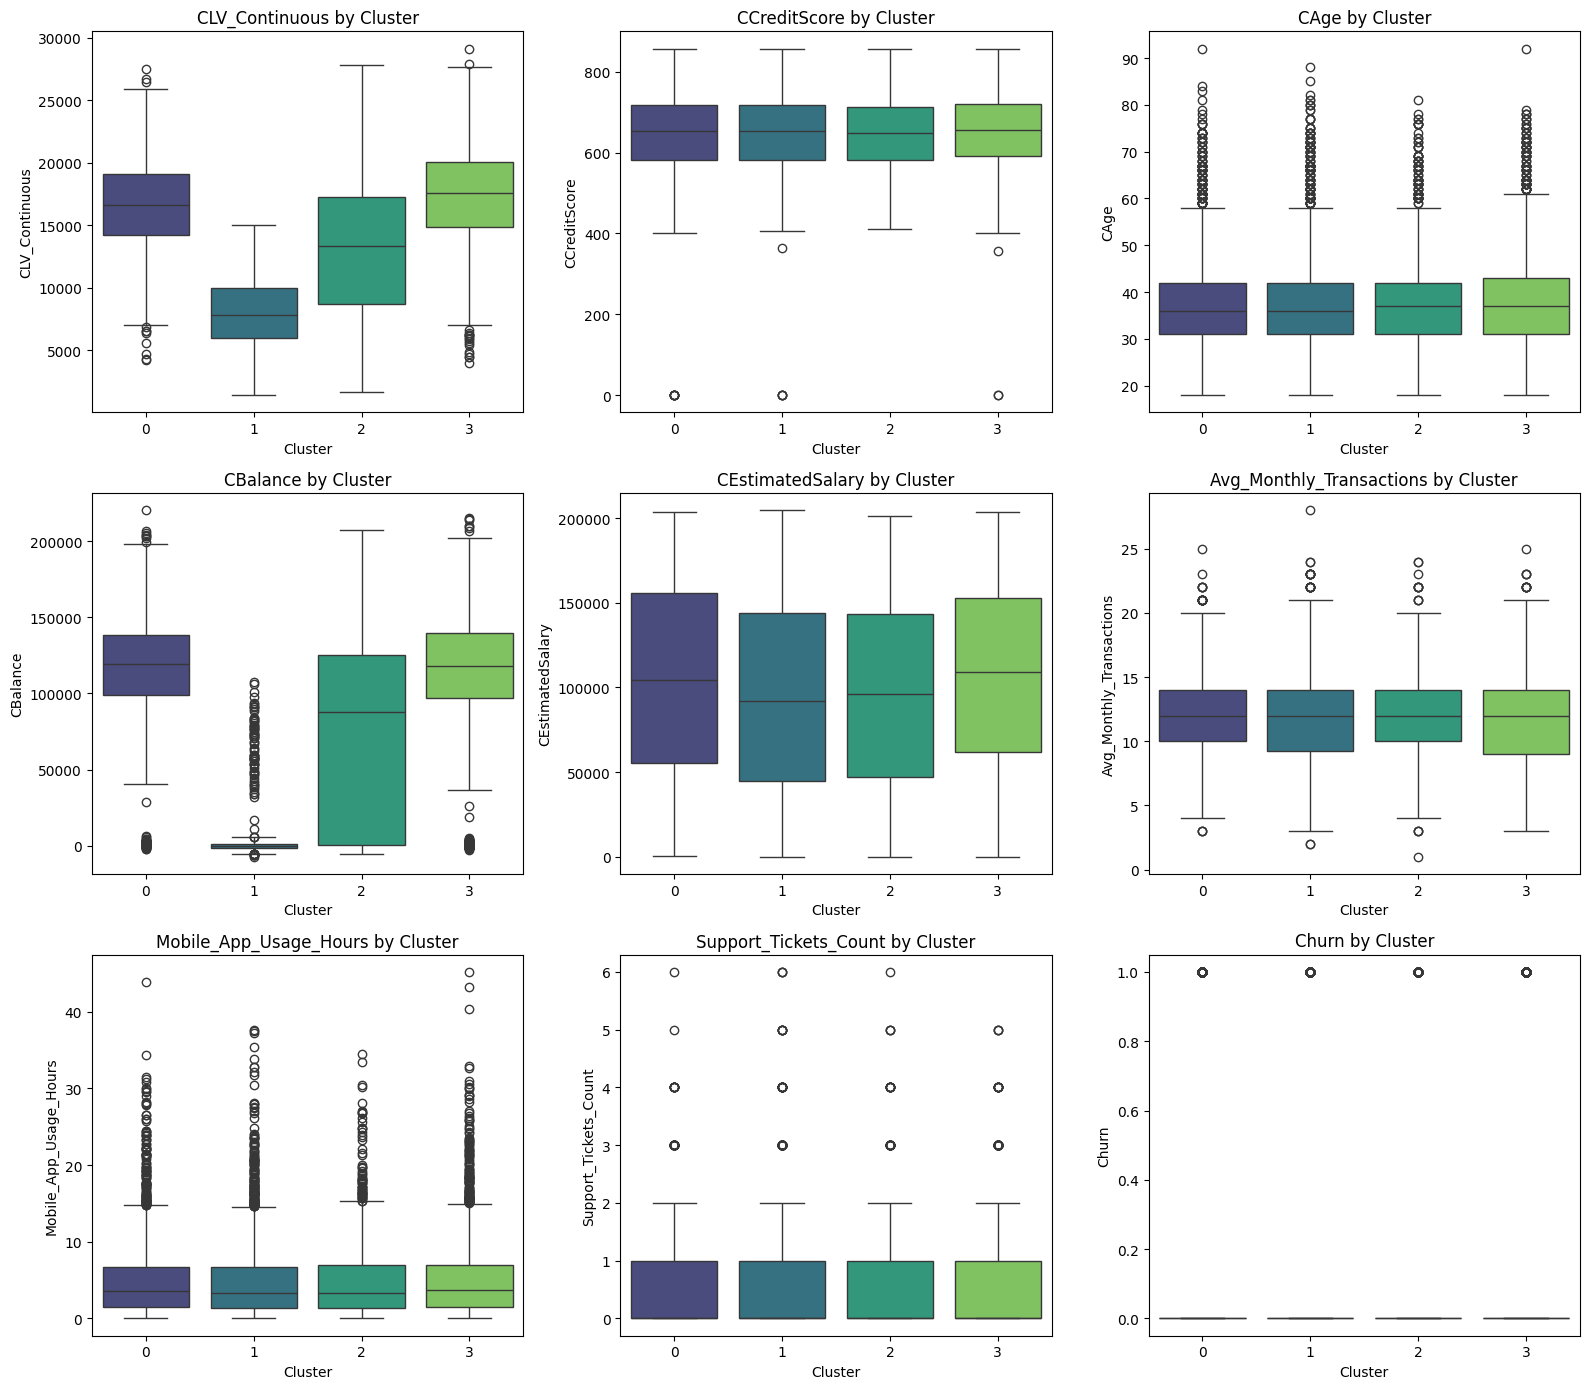

In [16]:
# Box plots comparing clusters across key features
fig, axes = plt.subplots(3, 3, figsize=(16, 14))
axes = axes.flatten()

plot_features = ['CLV_Continuous', 'CCreditScore', 'CAge', 'CBalance', 'CEstimatedSalary',
                 'Avg_Monthly_Transactions', 'Mobile_App_Usage_Hours', 'Support_Tickets_Count', 'Churn']

for i, feature in enumerate(plot_features):
    sns.boxplot(data=FinTech_clustered, x='Cluster', y=feature, ax=axes[i], palette='viridis')
    axes[i].set_title(f'{feature} by Cluster')
    axes[i].set_xlabel('Cluster')

plt.tight_layout()
plt.show()

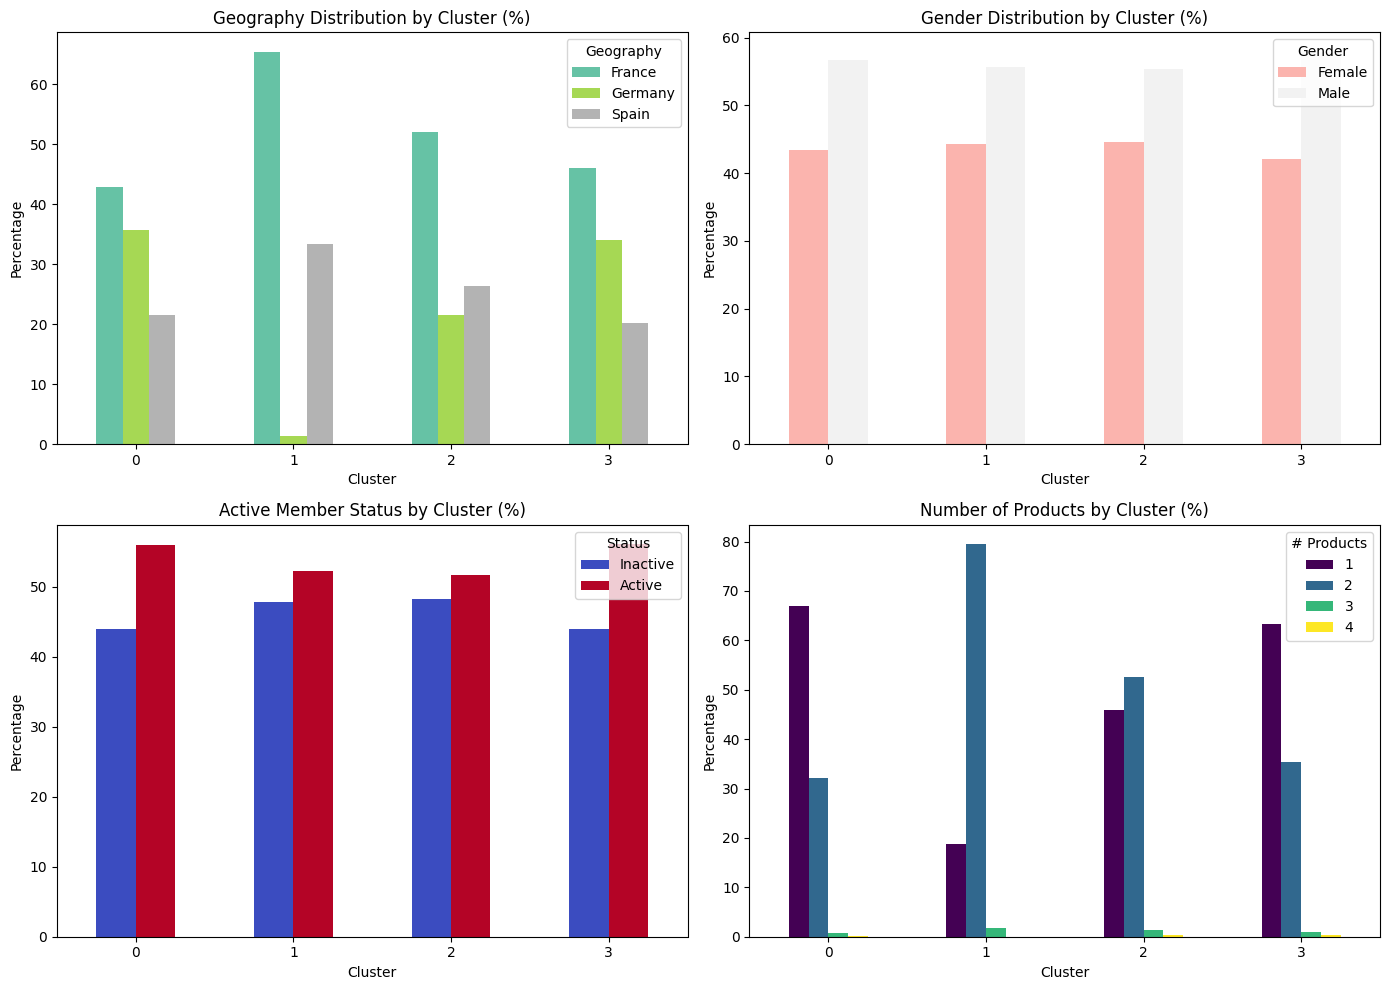

In [17]:
# Categorical feature distribution by cluster
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Geography distribution
geo_cluster = pd.crosstab(FinTech_clustered['Cluster'], FinTech_clustered['CGeography'], normalize='index') * 100
geo_cluster.plot(kind='bar', ax=axes[0, 0], colormap='Set2')
axes[0, 0].set_title('Geography Distribution by Cluster (%)')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Percentage')
axes[0, 0].legend(title='Geography')
axes[0, 0].tick_params(axis='x', rotation=0)

# Gender distribution
gender_cluster = pd.crosstab(FinTech_clustered['Cluster'], FinTech_clustered['CGender'], normalize='index') * 100
gender_cluster.plot(kind='bar', ax=axes[0, 1], colormap='Pastel1')
axes[0, 1].set_title('Gender Distribution by Cluster (%)')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Percentage')
axes[0, 1].legend(title='Gender')
axes[0, 1].tick_params(axis='x', rotation=0)

# Active Member distribution
active_cluster = pd.crosstab(FinTech_clustered['Cluster'], FinTech_clustered['CIsActiveMember'], normalize='index') * 100
active_cluster.columns = ['Inactive', 'Active']
active_cluster.plot(kind='bar', ax=axes[1, 0], colormap='coolwarm')
axes[1, 0].set_title('Active Member Status by Cluster (%)')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Percentage')
axes[1, 0].legend(title='Status')
axes[1, 0].tick_params(axis='x', rotation=0)

# Number of Products distribution
products_cluster = pd.crosstab(FinTech_clustered['Cluster'], FinTech_clustered['CNumOfProducts'], normalize='index') * 100
products_cluster.plot(kind='bar', ax=axes[1, 1], colormap='viridis')
axes[1, 1].set_title('Number of Products by Cluster (%)')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Percentage')
axes[1, 1].legend(title='# Products')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### Cluster Interpretation

Based on the analysis above, we can characterize each cluster segment. The specific characteristics will depend on the actual data values, but we provide a framework for interpretation based on typical patterns:

**Naming Convention**: Each cluster is assigned a descriptive name based on its dominant characteristics, considering:
- Customer Lifetime Value (CLV)
- Engagement level (transactions, app usage, activity status)
- Financial profile (balance, salary, credit score)
- Demographics (age, tenure)
- Churn risk

In [18]:
# Generate cluster descriptions based on relative characteristics
overall_means = FinTech_clustered[key_features].mean()

def describe_cluster(cluster_id, profiles, overall):
    """Generate a description for a cluster based on its characteristics relative to overall means."""
    cluster_data = profiles.loc[cluster_id]
    
    descriptions = []
    
    # CLV assessment
    clv_ratio = cluster_data['CLV_Continuous'] / overall['CLV_Continuous']
    if clv_ratio > 1.15:
        descriptions.append("High value customers (CLV significantly above average)")
    elif clv_ratio < 0.85:
        descriptions.append("Lower value customers (CLV below average)")
    else:
        descriptions.append("Average value customers (CLV near mean)")
    
    # Age assessment
    age_ratio = cluster_data['CAge'] / overall['CAge']
    if age_ratio > 1.1:
        descriptions.append("Older demographic")
    elif age_ratio < 0.9:
        descriptions.append("Younger demographic")
    
    # Engagement assessment
    app_ratio = cluster_data['Mobile_App_Usage_Hours'] / overall['Mobile_App_Usage_Hours']
    trans_ratio = cluster_data['Avg_Monthly_Transactions'] / overall['Avg_Monthly_Transactions']
    if app_ratio > 1.15 or trans_ratio > 1.15:
        descriptions.append("Highly engaged (frequent transactions/app usage)")
    elif app_ratio < 0.85 and trans_ratio < 0.85:
        descriptions.append("Low engagement")
    
    # Financial profile
    balance_ratio = cluster_data['CBalance'] / overall['CBalance'] if overall['CBalance'] != 0 else 1
    salary_ratio = cluster_data['CEstimatedSalary'] / overall['CEstimatedSalary']
    if balance_ratio > 1.15 and salary_ratio > 1.1:
        descriptions.append("High income, high balance")
    elif balance_ratio < 0.85 or salary_ratio < 0.9:
        descriptions.append("Lower financial capacity")
    
    # Churn risk
    churn_ratio = cluster_data['Churn'] / overall['Churn']
    if churn_ratio > 1.3:
        descriptions.append("HIGH CHURN RISK")
    elif churn_ratio < 0.7:
        descriptions.append("Low churn risk")
    
    return descriptions

# Print cluster descriptions
print("=" * 80)
print("CLUSTER SEGMENT DESCRIPTIONS")
print("=" * 80)

for cluster_id in range(OPTIMAL_K):
    desc = describe_cluster(cluster_id, cluster_profiles, overall_means)
    size = cluster_profiles.loc[cluster_id, 'Cluster_Size']
    pct = cluster_profiles.loc[cluster_id, 'Cluster_Pct']
    print(f"\n{'='*40}")
    print(f"CLUSTER {cluster_id}")
    print(f"Size: {size:.0f} customers ({pct}%)")
    print(f"{'='*40}")
    for d in desc:
        print(f"  • {d}")
    
    # Key metrics
    print(f"\n  Key Metrics:")
    print(f"    - Average CLV: ${cluster_profiles.loc[cluster_id, 'CLV_Continuous']:,.2f}")
    print(f"    - Average Age: {cluster_profiles.loc[cluster_id, 'CAge']:.1f} years")
    print(f"    - Avg Monthly Transactions: {cluster_profiles.loc[cluster_id, 'Avg_Monthly_Transactions']:.1f}")
    print(f"    - Churn Rate: {cluster_profiles.loc[cluster_id, 'Churn']*100:.1f}%")

CLUSTER SEGMENT DESCRIPTIONS

CLUSTER 0
Size: 2244 customers (25.9%)
  • High value customers (CLV significantly above average)

  Key Metrics:
    - Average CLV: $16,602.28
    - Average Age: 37.9 years
    - Avg Monthly Transactions: 12.1
    - Churn Rate: 8.0%

CLUSTER 1
Size: 2614 customers (30.2%)
  • Lower value customers (CLV below average)
  • Lower financial capacity
  • Low churn risk

  Key Metrics:
    - Average CLV: $7,991.10
    - Average Age: 37.7 years
    - Avg Monthly Transactions: 12.1
    - Churn Rate: 5.0%

CLUSTER 2
Size: 1422 customers (16.4%)
  • Average value customers (CLV near mean)

  Key Metrics:
    - Average CLV: $13,147.04
    - Average Age: 37.9 years
    - Avg Monthly Transactions: 12.0
    - Churn Rate: 7.0%

CLUSTER 3
Size: 2382 customers (27.5%)
  • High value customers (CLV significantly above average)

  Key Metrics:
    - Average CLV: $17,436.84
    - Average Age: 38.3 years
    - Avg Monthly Transactions: 11.8
    - Churn Rate: 9.0%


## Task 4: Marketing Recommendations
Translate these findings into real-world business strategies.

- Propose actionable marketing strategies for each customer segment. Think about how the
marketing team can create targeted campaigns that resonate with each group.

### Marketing Strategy Framework

Based on the cluster profiles identified above, we propose targeted marketing strategies for each customer segment. The strategies are aligned with each cluster's unique characteristics, focusing on:

1. **Retention strategies** for high-value, low-churn customers
2. **Re-engagement campaigns** for at-risk customers
3. **Growth strategies** to increase CLV of developing customers
4. **Acquisition cost optimization** based on customer potential

In [19]:
# Generate marketing recommendations based on cluster characteristics
def generate_marketing_recommendations(cluster_id, profiles, overall):
    """Generate marketing recommendations for each cluster."""
    cluster_data = profiles.loc[cluster_id]
    
    recommendations = {
        'segment_name': '',
        'priority': '',
        'channels': [],
        'campaigns': [],
        'products': [],
        'retention_strategy': ''
    }
    
    # Calculate key ratios
    clv_ratio = cluster_data['CLV_Continuous'] / overall['CLV_Continuous']
    churn_ratio = cluster_data['Churn'] / overall['Churn']
    engagement_ratio = (cluster_data['Mobile_App_Usage_Hours'] / overall['Mobile_App_Usage_Hours'] + 
                       cluster_data['Avg_Monthly_Transactions'] / overall['Avg_Monthly_Transactions']) / 2
    age_ratio = cluster_data['CAge'] / overall['CAge']
    
    # Determine segment name and priority
    if clv_ratio > 1.15 and churn_ratio < 0.8:
        recommendations['segment_name'] = "Premium Loyalists"
        recommendations['priority'] = "RETAIN & REWARD"
        recommendations['channels'] = ["Personalized email", "Dedicated account manager", "Exclusive app features"]
        recommendations['campaigns'] = [
            "VIP loyalty program with premium rewards",
            "Early access to new products/features",
            "Referral bonus program",
            "Exclusive investment opportunities"
        ]
        recommendations['products'] = ["Premium credit cards", "Investment portfolios", "Wealth management services"]
        recommendations['retention_strategy'] = "Focus on maintaining relationship through personalized service and exclusive benefits"
        
    elif clv_ratio > 1.15 and churn_ratio >= 0.8:
        recommendations['segment_name'] = "At-Risk High Value"
        recommendations['priority'] = "URGENT RETENTION"
        recommendations['channels'] = ["Personal phone calls", "Targeted emails", "In-app notifications"]
        recommendations['campaigns'] = [
            "Win-back offers with special rates",
            "Satisfaction surveys with immediate follow-up",
            "Personalized product recommendations",
            "Fee waivers or temporary benefits"
        ]
        recommendations['products'] = ["Service upgrades at reduced rates", "Bundled products with discounts"]
        recommendations['retention_strategy'] = "Immediate intervention with personalized retention offers; identify pain points through direct outreach"
        
    elif clv_ratio < 0.85 and engagement_ratio > 1:
        recommendations['segment_name'] = "Engaged Developers"
        recommendations['priority'] = "GROW CLV"
        recommendations['channels'] = ["Mobile app push notifications", "In-app promotions", "Gamification"]
        recommendations['campaigns'] = [
            "Product upgrade incentives",
            "Transaction-based rewards",
            "Financial literacy content",
            "Cross-sell campaigns for additional products"
        ]
        recommendations['products'] = ["Savings accounts", "Budget tracking tools", "Entry-level investment products"]
        recommendations['retention_strategy'] = "Nurture engagement while gradually introducing higher-value products"
        
    elif churn_ratio > 1.2:
        recommendations['segment_name'] = "High Churn Risk"
        recommendations['priority'] = "RE-ENGAGE"
        recommendations['channels'] = ["Email re-engagement", "SMS reminders", "Retargeting ads"]
        recommendations['campaigns'] = [
            "Reactivation offers",
            "Feature highlight campaigns",
            "Feedback collection for improvement",
            "Limited-time promotional rates"
        ]
        recommendations['products'] = ["Simplified product offerings", "Low-commitment starter products"]
        recommendations['retention_strategy'] = "Understand reasons for disengagement; offer simplified value proposition"
        
    elif age_ratio < 0.9:
        recommendations['segment_name'] = "Digital Natives"
        recommendations['priority'] = "DIGITAL FIRST"
        recommendations['channels'] = ["Social media", "Mobile app", "Influencer partnerships"]
        recommendations['campaigns'] = [
            "Social media engagement campaigns",
            "Peer referral programs",
            "App-exclusive features and rewards",
            "Financial education content"
        ]
        recommendations['products'] = ["Mobile-first banking", "Crypto/investment apps", "Buy-now-pay-later"]
        recommendations['retention_strategy'] = "Build long-term relationship through digital-native experiences"
        
    else:
        recommendations['segment_name'] = "Stable Mainstream"
        recommendations['priority'] = "OPTIMIZE"
        recommendations['channels'] = ["Email marketing", "App notifications", "Branch visits (if applicable)"]
        recommendations['campaigns'] = [
            "Lifecycle marketing based on tenure",
            "Product adoption campaigns",
            "Regular engagement touchpoints",
            "Customer anniversary recognition"
        ]
        recommendations['products'] = ["Balanced product portfolio", "Auto-save features", "Insurance products"]
        recommendations['retention_strategy'] = "Maintain steady relationship with regular value-added communications"
    
    return recommendations

# Display marketing recommendations for each cluster
print("=" * 80)
print("MARKETING RECOMMENDATIONS BY SEGMENT")
print("=" * 80)

for cluster_id in range(OPTIMAL_K):
    rec = generate_marketing_recommendations(cluster_id, cluster_profiles, overall_means)
    size = cluster_profiles.loc[cluster_id, 'Cluster_Size']
    pct = cluster_profiles.loc[cluster_id, 'Cluster_Pct']
    
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id}: {rec['segment_name']}")
    print(f"Size: {size:.0f} customers ({pct}%)")
    print(f"Priority: {rec['priority']}")
    print(f"{'='*70}")
    
    print(f"\n  📱 Preferred Channels:")
    for channel in rec['channels']:
        print(f"      • {channel}")
    
    print(f"\n  📣 Recommended Campaigns:")
    for campaign in rec['campaigns']:
        print(f"      • {campaign}")
    
    print(f"\n  🎯 Target Products:")
    for product in rec['products']:
        print(f"      • {product}")
    
    print(f"\n  🔒 Retention Strategy:")
    print(f"      {rec['retention_strategy']}")

MARKETING RECOMMENDATIONS BY SEGMENT

CLUSTER 0: At-Risk High Value
Size: 2244 customers (25.9%)
Priority: URGENT RETENTION

  📱 Preferred Channels:
      • Personal phone calls
      • Targeted emails
      • In-app notifications

  📣 Recommended Campaigns:
      • Win-back offers with special rates
      • Satisfaction surveys with immediate follow-up
      • Personalized product recommendations
      • Fee waivers or temporary benefits

  🎯 Target Products:
      • Service upgrades at reduced rates
      • Bundled products with discounts

  🔒 Retention Strategy:
      Immediate intervention with personalized retention offers; identify pain points through direct outreach

CLUSTER 1: Stable Mainstream
Size: 2614 customers (30.2%)
Priority: OPTIMIZE

  📱 Preferred Channels:
      • Email marketing
      • App notifications
      • Branch visits (if applicable)

  📣 Recommended Campaigns:
      • Lifecycle marketing based on tenure
      • Product adoption campaigns
      • Regular enga

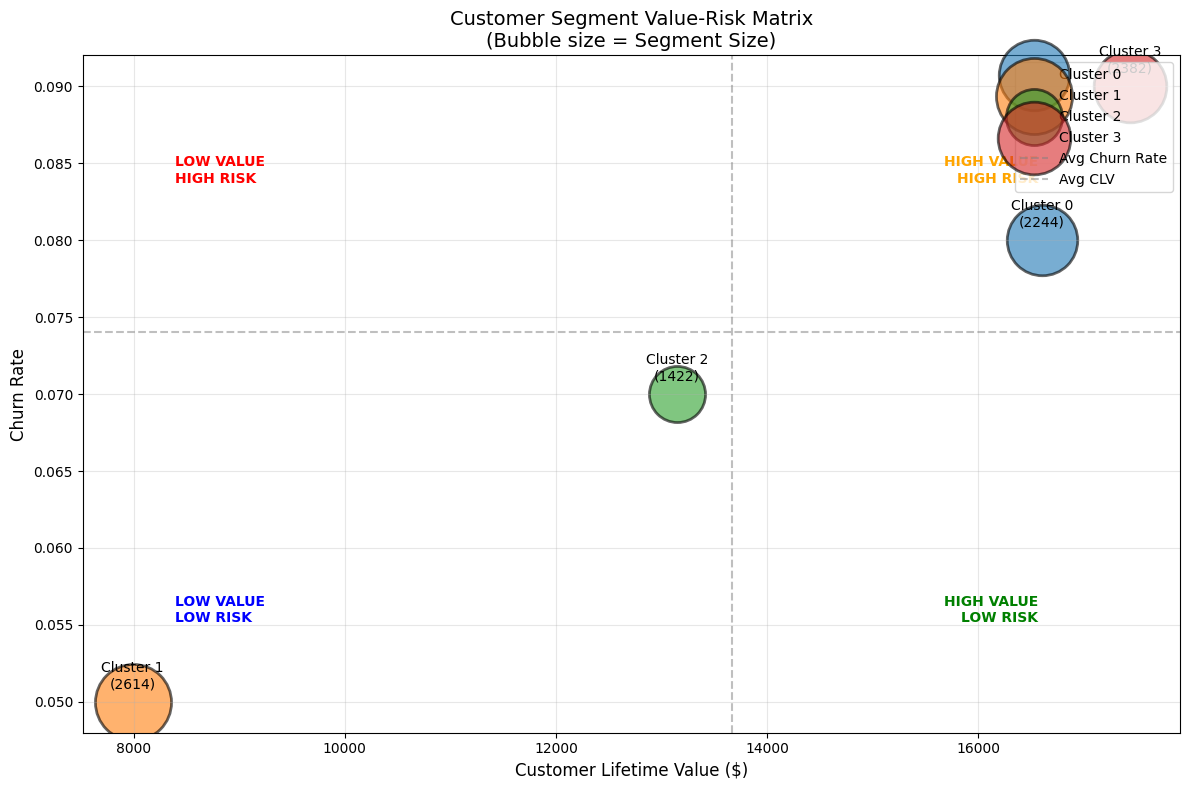

In [20]:
# Visualization: Segment Value vs Churn Risk Matrix
fig, ax = plt.subplots(figsize=(12, 8))

# Calculate metrics for each cluster
cluster_clv = cluster_profiles['CLV_Continuous']
cluster_churn = cluster_profiles['Churn']
cluster_sizes = cluster_profiles['Cluster_Size']

# Normalize sizes for bubble chart
size_normalized = (cluster_sizes / cluster_sizes.max()) * 3000

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for i in range(OPTIMAL_K):
    ax.scatter(cluster_clv.iloc[i], cluster_churn.iloc[i], 
               s=size_normalized.iloc[i], c=colors[i], alpha=0.6, 
               edgecolors='black', linewidth=2, label=f'Cluster {i}')
    ax.annotate(f'Cluster {i}\n({cluster_sizes.iloc[i]:.0f})', 
                (cluster_clv.iloc[i], cluster_churn.iloc[i]),
                textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)

# Add reference lines at overall means
ax.axhline(y=overall_means['Churn'], color='gray', linestyle='--', alpha=0.5, label='Avg Churn Rate')
ax.axvline(x=overall_means['CLV_Continuous'], color='gray', linestyle='--', alpha=0.5, label='Avg CLV')

# Add quadrant labels
ax.text(cluster_clv.max()*0.95, cluster_churn.min()*1.1, 'HIGH VALUE\nLOW RISK', 
        ha='right', va='bottom', fontsize=10, color='green', fontweight='bold')
ax.text(cluster_clv.min()*1.05, cluster_churn.max()*0.95, 'LOW VALUE\nHIGH RISK', 
        ha='left', va='top', fontsize=10, color='red', fontweight='bold')
ax.text(cluster_clv.max()*0.95, cluster_churn.max()*0.95, 'HIGH VALUE\nHIGH RISK', 
        ha='right', va='top', fontsize=10, color='orange', fontweight='bold')
ax.text(cluster_clv.min()*1.05, cluster_churn.min()*1.1, 'LOW VALUE\nLOW RISK', 
        ha='left', va='bottom', fontsize=10, color='blue', fontweight='bold')

ax.set_xlabel('Customer Lifetime Value ($)', fontsize=12)
ax.set_ylabel('Churn Rate', fontsize=12)
ax.set_title('Customer Segment Value-Risk Matrix\n(Bubble size = Segment Size)', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Executive Summary

This clustering analysis successfully segmented the FinTech customer base into 4 distinct groups using K-Means clustering. The key findings and recommendations are:

**Key Insights:**
1. Customers can be meaningfully segmented based on their financial behavior, engagement levels, and demographics
2. Each segment shows distinct patterns in CLV, churn risk, and product usage
3. The segmentation provides actionable insights for targeted marketing strategies

**Strategic Priorities:**
1. **Protect high-value customers** through personalized retention strategies
2. **Re-engage at-risk segments** with targeted win-back campaigns
3. **Develop growth potential** in engaged but lower-value customers
4. **Optimize acquisition costs** by focusing on segments with highest conversion potential

**Recommended Next Steps:**
1. Implement segment-specific marketing campaigns
2. Develop predictive models for each segment to anticipate behavior changes
3. Create personalized product recommendations based on segment characteristics
4. Monitor segment migration over time to adjust strategies accordingly
5. A/B test marketing messages within each segment to optimize engagement